## Interpolation Test Stimuli Performance V3

Two objectives:
- Training Data
- Model comparison
    - collapsed, and by individual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from behav import plotting, utils, loading
from starling_rhythm.utils.analysis import stim_parser, plot_subject_acquisition, acquisition_data_preprocessing

from starling_rhythm.utils.paths import PROCESSED_DIR, FIGURE_DIR
import pandas as pd

import seaborn as sns
sns.set_style("ticks")

data_path = '/mnt/cube/RawData/Magpi/'

subjects = (
    ['B1520', 'B1535']
)

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
%%time
behav_data = loading.load_data_pandas(subjects, data_path)

CPU times: user 1.59 s, sys: 96 ms, total: 1.68 s
Wall time: 19.2 s


## Clean debug trials and parse stim info

In [4]:
behav_data['B1520'] = behav_data['B1520'][behav_data['B1520'].index > '2023-01-19 00:00:00.000000'] 
## B1520 started trials on the 19th, previous are debug trials

behav_data['B1535'] = behav_data['B1535'][behav_data['B1535'].index > '2023-01-20 00:00:00.000000'] 
## B1535 started trials on the 20th, previous are debug trials

In [5]:
behav_data = stim_parser(behav_data)

Output stim labels for B1520: 113542it [00:11, 9818.90it/s] 
Output stim labels for B1535: 107592it [00:10, 10022.58it/s]


### For every test trial, only keep if the previous 100 trial accuracy is > 0.8

In [15]:
from starling_rhythm.utils.analysis import test_filter

In [16]:
test_data, training_data = test_filter(behav_data, accuracy_threshold = 0.8, past_baseline_trials = 100)

Iterating through test trials for subject B1520: 4718it [00:03, 1239.24it/s]
Iterating through test trials for subject B1535: 4153it [00:02, 1526.61it/s]


## Plot acquisition data

Plot accuracy (y) over time (x) for each stimuli

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [
/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [


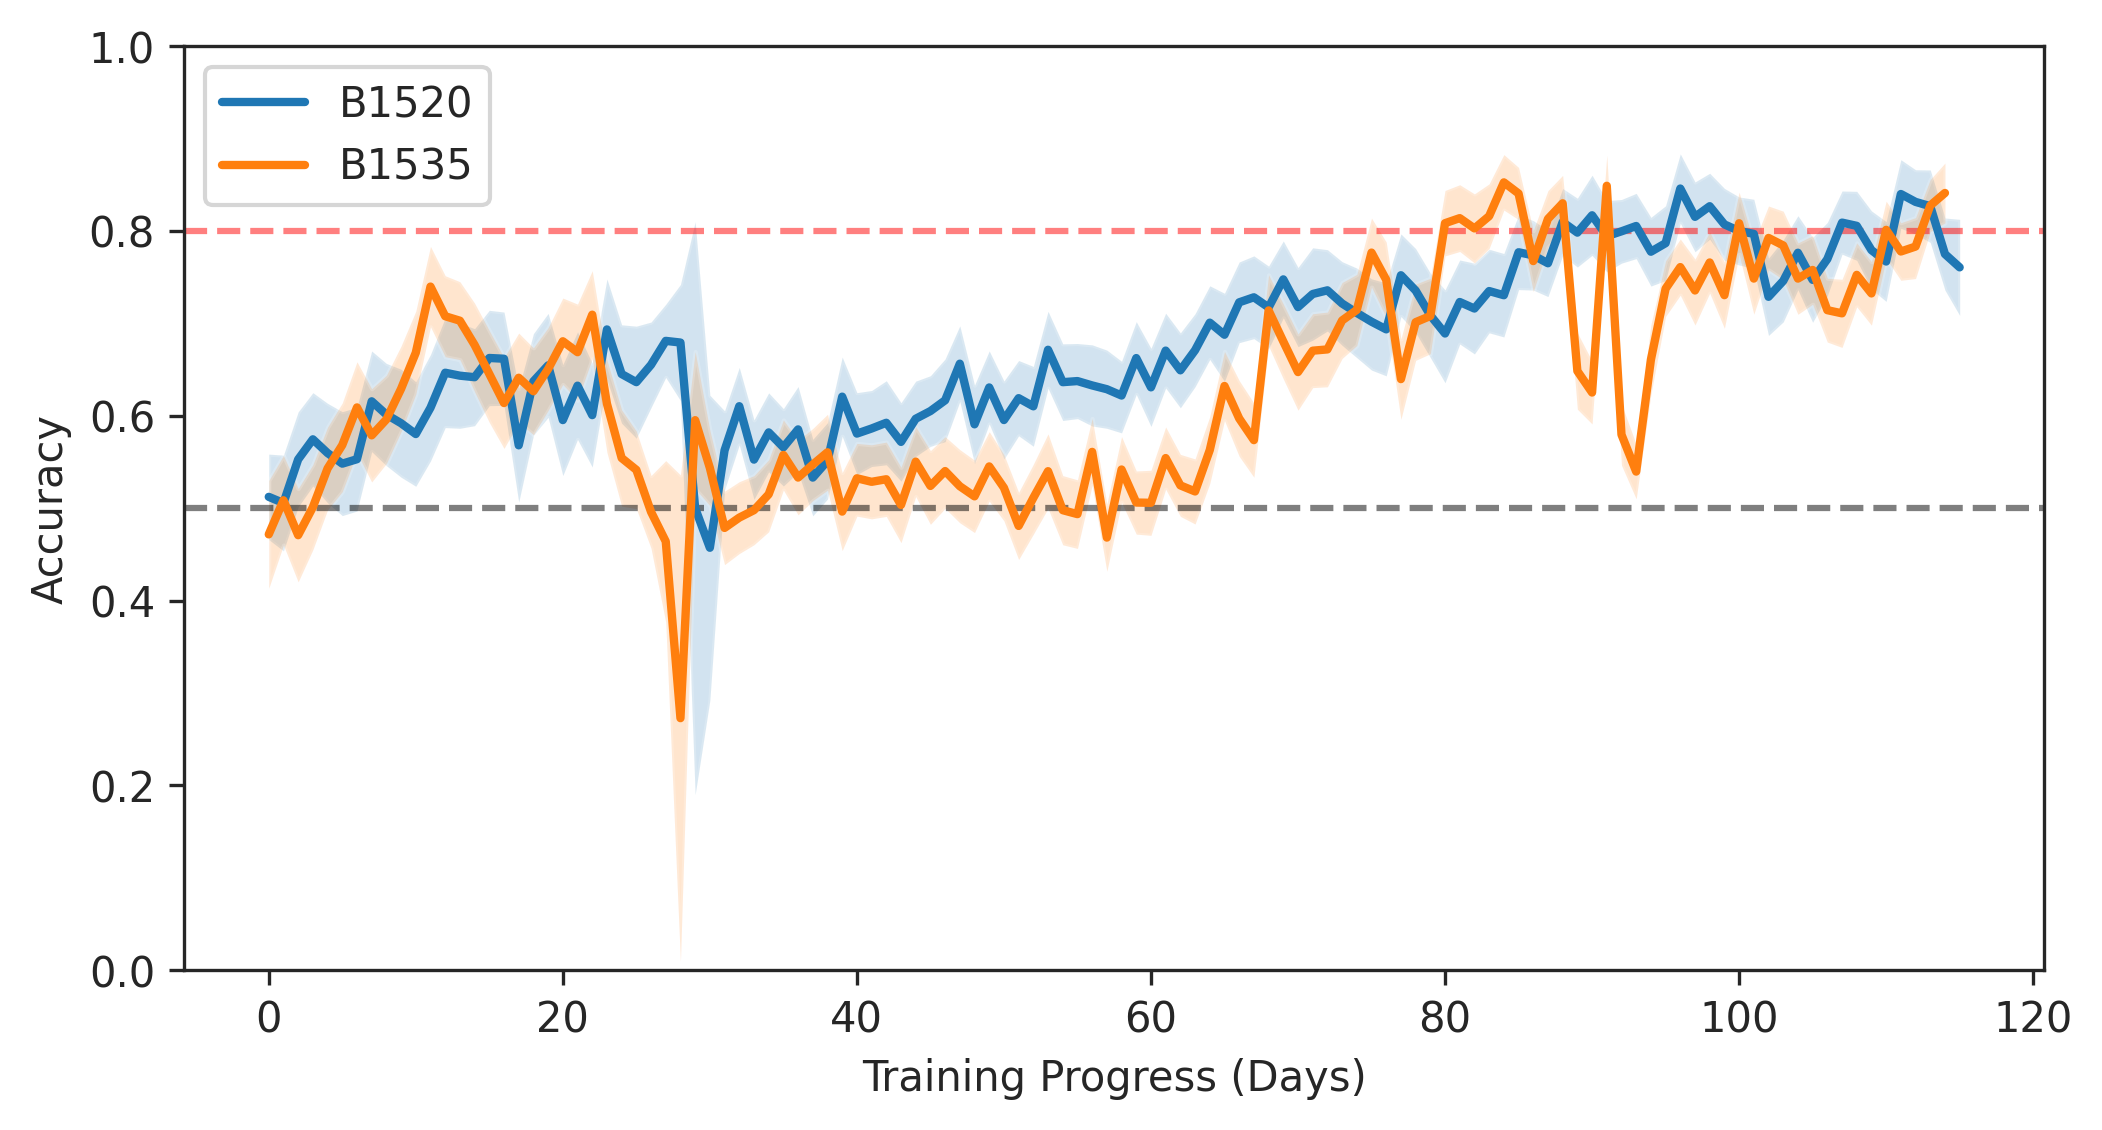

In [17]:
plot_subject_acquisition(behav_data)

plt.savefig(FIGURE_DIR / 'F4_A_acquisition.pdf', dpi = 'figure', format = 'pdf', transparent = True)

## Plot pre-test data by bird and stimuli

In [28]:
from statsmodels.stats.proportion import proportion_confint

In [23]:
trainB1520 = behav_data['B1520'].reset_index()
trainB1535 = behav_data['B1535'].reset_index()

trainB1520['bID'] = 'B1520'
trainB1535['bID'] = 'B1535'

trainB1520 = trainB1520[trainB1520.type_ == 'normal']
trainB1535 = trainB1535[trainB1535.type_ == 'normal']

trainB1520 = trainB1520[trainB1520.time < test_data['B1520'].time.values[0]]
trainB1535 = trainB1535[trainB1535.time < test_data['B1535'].time.values[0]]

trainB1520 = trainB1520.iloc[-1000:]
trainB1535 = trainB1535.iloc[-1000:]

pretest = pd.concat([trainB1520, trainB1535])

In [24]:
groupby_list = ['bID', 'pair_indices', 'inter_nums']

In [26]:
pretest_data = pd.DataFrame(
    pretest.groupby(
        groupby_list
    )['correct'].agg(['mean', 'count'])
)

In [29]:
pretest_data

mean  count
bID   pair_indices inter_nums                 
B1520 0            max         0.917012    241
                   min         0.738197    233
      1            max         0.819328    238
                   min         0.738095    252
B1535 0            max         0.669421    242
                   min         0.842105    247
      1            max         0.585062    241
                   min         0.741036    251

In [32]:
## calculate binomial CI
binomial_lower = []
binomial_upper = []

for i, row in pretest_data.iterrows():
    
    try:
        lower, upper = proportion_confint(int(row['mean'] * row['count']), row['count'], alpha = 0.05)
    except:
        lower = np.nan
        upper = np.nan
    
    binomial_lower.append(lower)
    binomial_upper.append(upper)
    
pretest_data['lower'] = binomial_lower
pretest_data['upper'] = binomial_upper

In [36]:
pretest_data = pretest_data.reset_index()

In [43]:
pretest_data['dummy_names'] = pretest_data['pair_indices'] + pretest_data['inter_nums']

In [44]:
pretest_data

,bID,pair_indices,inter_nums,mean,count,lower,upper,dummy_names
0,B1520,0,max,0.917012,241,0.882184,0.951841,0max
1,B1520,0,min,0.738197,233,0.681750,0.794645,0min
2,B1520,1,max,0.819328,238,0.770447,0.868208,1max
3,B1520,1,min,0.738095,252,0.683811,0.792380,1min
4,B1535,0,max,0.669421,242,0.610152,0.728690,0max
5,B1535,0,min,0.842105,247,0.796631,0.887580,0min
6,B1535,1,max,0.585062,241,0.522856,0.647268,1max
7,B1535,1,min,0.741036,251,0.686842,0.795230,1min


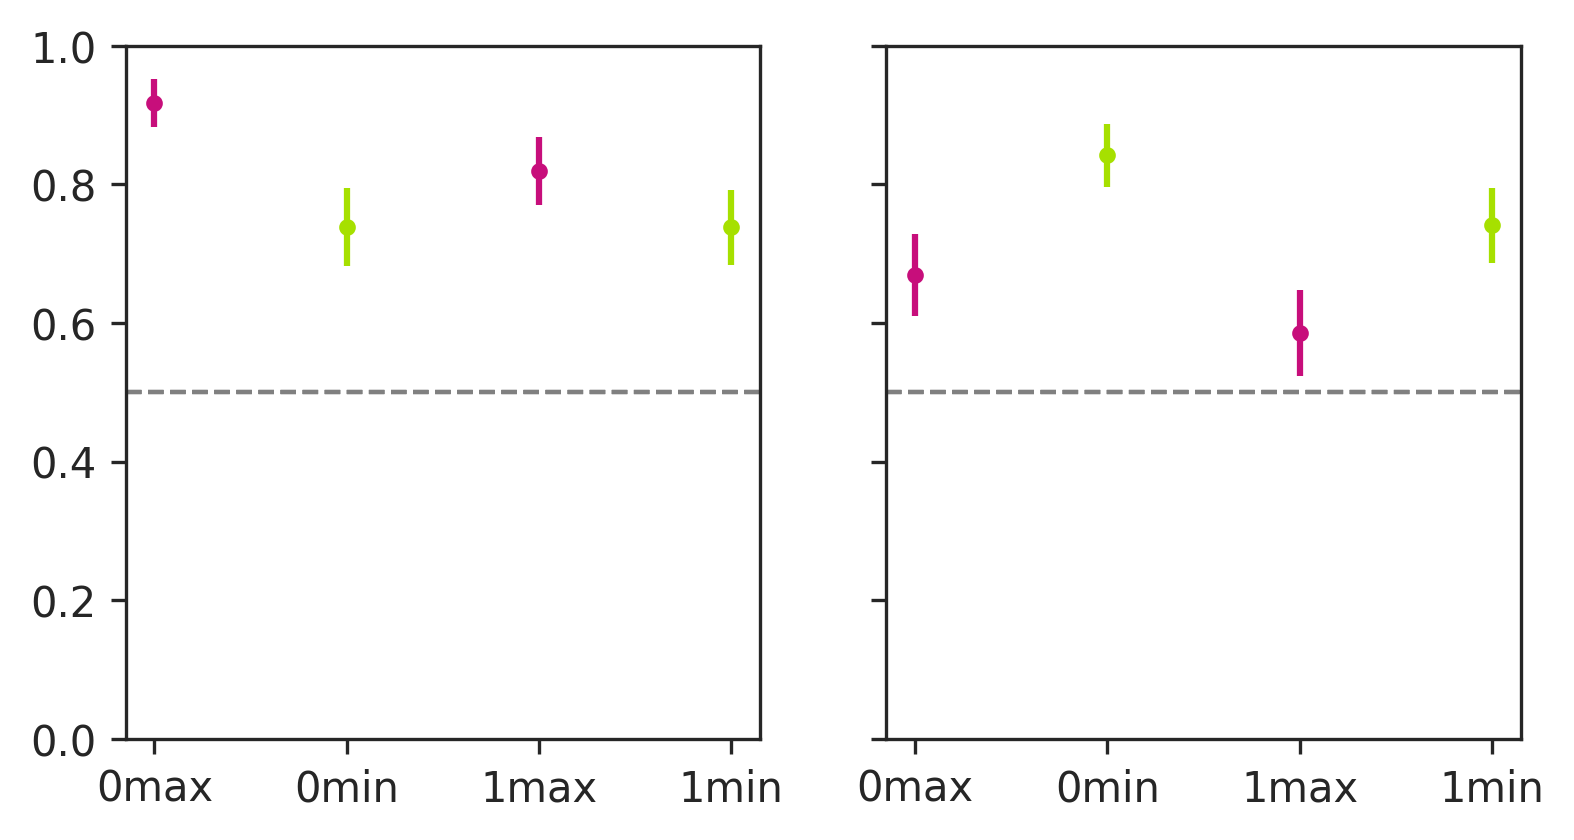

In [77]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), dpi = 300, sharey = True)

colors = ["#C70E7B","#A6E000","#C70E7B","#A6E000", "#C70E7B","#A6E000","#C70E7B","#A6E000"]
sns.set_palette(sns.color_palette(colors))

for i, bID in zip(np.arange(0, len(np.unique(pretest_data['bID']))), np.unique(pretest_data['bID'])):
    select = pretest_data[pretest_data.bID == bID]
    for j, row in select.iterrows():
        axes[i].errorbar(x = row.dummy_names, y = row['mean'], yerr = [[row['mean'] - row.lower], [row.upper - row['mean']]], fmt = 'none', color = colors[j])
        axes[i].plot(row.dummy_names, row['mean'], marker = '.', color = colors[j])
        axes[i].axhline(y = 0.5, linewidth = 1, ls = '--', color = 'gray')

axes[0].set_ylim([0, 1])

plt.savefig(FIGURE_DIR / 'F4_B_pretest.pdf', dpi = 'figure', format = 'pdf', transparent = True)